# Transcription by Kaggler

- This notebook is for transcription.
- Purpose for doing this is to increase my ability to analyze data, modeling.

In [1]:
import pandas as pd
import numpy as np
import os
os.chdir("../../data/sf-crime")

train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

print(f"Shape of train data : {train.shape}")
print(f"Shape of test data : {test.shape}")

Shape of train data : (878049, 9)
Shape of test data : (884262, 7)


In [3]:
# 데이터를 로드하면 우선 Duplicated data가 있는지 확인하자!
train.duplicated().sum()

2323

In [5]:
import geopandas as gpd

In [11]:
from shapely.geometry import Point

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


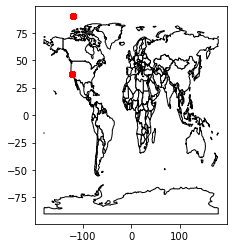

In [16]:
# geopandas를 이용해 경도, 위도값을 살펴봤을 때 미국 외에 잘못 기록된 곳이 있다.
import matplotlib.pyplot as plt
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(gdf,
                          geometry='Coordinates',
                          crs={'init':'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

In [17]:
import warnings
warnings.filterwarnings(action='ignore')

In [20]:
train_gdf[['X','Y','Coordinates']].head()

,X,Y,Coordinates
0,-122.425892,37.774599,POINT (-122.42589 37.77460)
1,-122.425892,37.774599,POINT (-122.42589 37.77460)
2,-122.424363,37.800414,POINT (-122.42436 37.80041)
3,-122.426995,37.800873,POINT (-122.42700 37.80087)
4,-122.438738,37.771541,POINT (-122.43874 37.77154)


In [24]:
# 위도값이 40이 넘어가는 데이터 출력
print(train_gdf.loc[train_gdf.Y > 40].count()[0])
print()
# 그 중에 5개 데이터만 출력해보기
train_gdf.loc[train_gdf.Y > 40].sample(5)

67



,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Coordinates
687519,2005-08-13 17:00:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Saturday,TENDERLOIN,NONE,JENNINGS CT / INGALLS ST,-120.5,90.0,POINT (-120.50000 90.00000)
767501,2004-06-24 00:03:00,DISORDERLY CONDUCT,COMMITTING PUBLIC NUISANCE,Thursday,NORTHERN,"ARREST, BOOKED",AUSTIN ST / LARKIN ST,-120.5,90.0,POINT (-120.50000 90.00000)
687527,2005-08-13 17:00:00,VEHICLE THEFT,"VEHICLE, RECOVERED, AUTO",Saturday,TENDERLOIN,NONE,JENNINGS CT / INGALLS ST,-120.5,90.0,POINT (-120.50000 90.00000)
788574,2004-03-17 01:16:00,DISORDERLY CONDUCT,COMMITTING PUBLIC NUISANCE,Wednesday,NORTHERN,"ARREST, BOOKED",LARKIN ST / AUSTIN ST,-120.5,90.0,POINT (-120.50000 90.00000)
686997,2005-08-22 01:39:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Monday,NORTHERN,NONE,AUSTIN ST / LARKIN ST,-120.5,90.0,POINT (-120.50000 90.00000)


- 위에 처럼 위도가 벗어난 지역들은 해당 데이터의 District와 동일한 지역을 기준으로 그 지역들의 평균값으로 Coordinates를 대체


- SimpleImputer 클래스에서 몇 가지 달라진 점이 있습니다. missing_values 매개변수에 NaN을 지정할 때 문자열 ‘NaN’이 아니라 np.nan을 사용합니다. missing_values의 기본값이 np.nan입니다. strategy 매개변수에 mean, median, most_frequent 외에 constant가 추가되었습니다. strategy='constant'일 때 fill_value 매개변수에 채우려는 값을 지정합니다. SimpleImputer에는 axis 매개변수가 없습니다. 기본 동작 방식은 Imputer 클래스의 axis=0일 때와 같습니다. 행 방향으로 대체할 값을 계산하려면 FunctionTransformer를 사용하여 처리할 수 있습니다. 다음 코드는 입력 행렬의 행과 열을 바꾸어 대체할 값을 계산한 후 다시 변환된 행렬의 열과 행을 바꿉니다.

In [26]:
# 우선 중복 데이터 삭제
train.drop_duplicates(inplace=True)

In [27]:
from sklearn.impute import SimpleImputer
# 위,경도가 -120.5 , 90.0 으로 잘못 매핑된 데이터들을 na값으로 대체
# replace함수에 dict형태를 지정해줌으로써 '어떤 칼럼에 어떤값을' 지정 가능!
train.replace({'X': -120.5, 'Y': 90.0}, np.nan, inplace=True)
test.replace({'X': -120.5, 'Y':90.0}, np.nan, inplace=True)

# 결측치를 대체하는 SimpleImputer할당
imp = SimpleImputer(strategy='mean')

# train, test 데이터에서 위,경도 결측치를 District에 맞는 위,경도로 대체
districts = train['PdDistrict'].unique()
for district in districts:
    train.loc[train['PdDistrict'] == district, ['X','Y']] = imp.fit_transform(train.loc[train['PdDistrict'] == district, ['X','Y']])
    test.loc[test['PdDistrict'] == district, ['X','Y']] = imp.fit_transform(test.loc[test['PdDistrict'] == district, ['X','Y']])
    
# 결측치 제대로 채운 다음 다시 위,경도 point 만들어내주는 함수 적용
train_gdf = create_gdf(train)

In [31]:
train['Dates'] = pd.to_datetime(train['Dates'])

In [33]:
train['Date'] = train.Dates.dt.date
train['Hour'] = train.Dates.dt.hour
train.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,Hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,23


In [35]:
# Date별로 그룹핑해서 얼마나 범죄가 발생했는지 count하기
# .iloc하는 이유는 어차피 그룹핑한 후 칼럼의 값들이 다 똑같기 때문에 첫번째 칼럼값만 갖고옴
data = train.groupby('Date').count().iloc[:,0]
data.head()

Date
2003-01-06    400
2003-01-07    417
2003-01-08    523
2003-01-09    416
2003-01-10    397
Name: Dates, dtype: int64

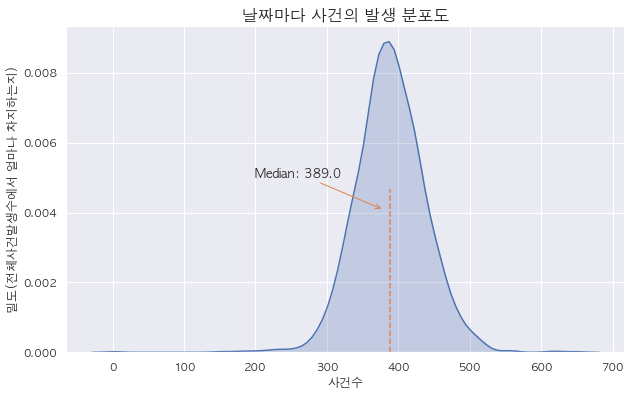

In [46]:
import seaborn as sns
sns.set(font='AppleGothic')

col = sns.color_palette()
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, shade=True)
# Per Date 범죄 발생건수 중앙값을 line으로 표시하는 방법
plt.axvline(x=data.median(), ymax=0.5,
           linestyle='--', color=col[1])
# 
plt.annotate(
    'Median: '+str(data.median()),
    xy=(data.median(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color=col[1],
                   shrinkB=10))
plt.title('날짜마다 사건의 발생 분포도', fontdict={'fontsize':16})
plt.xlabel('사건수')
plt.ylabel('밀도(전체사건발생수에서 얼마나 차지하는지)')
plt.legend().remove()
plt.show()

# 날짜(월요일~금요일)에 따른 사건의 빈도수의 표준편차가 크지 않다.
# 따라서 예측하는 데 있어서 날짜가 중요한 역할을 할 변수이진 않을 것이다.